In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gc
import seaborn as sns
pd.options.mode.chained_assignment = None

import category_encoders as ce

## Import Data

In [3]:
orders = pd.read_csv("C:\\Users\\hmitt\\Downloads\\Team23_Project\\datasets\\orders.csv",
                     dtype={'order_id':np.uint32,
                              'order_number':'uint8',
                              'user_id' :np.uint32,                                                                                                  
                              'order_hour_of_day':'uint8',
                              'order_dow':'uint8',
                              'days_since_prior_order':'float16'})
departments = pd.read_csv('C:\\Users\\hmitt\\Downloads\\Team23_Project\\datasets\\departments.csv',
                          dtype={'department_id':'uint8',
                                 'department': str})
aisles = pd.read_csv('C:\\Users\\hmitt\\Downloads\\Team23_Project\\datasets\\aisles.csv', 
                     dtype={'aisle_id':'uint8',
                            'aisle': str})
products = pd.read_csv('C:\\Users\\hmitt\\Downloads\\Team23_Project\\datasets\\products.csv', 
                       dtype={'aisle_id':'uint8',
                             'department_id':'uint8',
                             'product_name': str,
                             'product_id': np.uint16})
order_products_prior = pd.read_csv('C:\\Users\\hmitt\\Downloads\\Team23_Project\\datasets\\order_products__prior.csv',
                                   dtype={'add_to_cart_order':'uint8',
                                          'reordered':'uint8',
                                          'order_id':np.uint32,
                                          'product_id':np.uint16})
order_products_train = pd.read_csv('C:\\Users\\hmitt\\Downloads\\Team23_Project\\datasets\\order_products__train.csv',
                                   dtype={'add_to_cart_order':'uint8',
                                          'reordered':'uint8',
                                          'order_id':np.uint32,
                                          'product_id':np.uint16})

print(aisles.head(5))
print(departments.head(5))
print(order_products_prior.head(5))
print(order_products_train.head(5))
print(products.head(5))
print(orders.head(5))


   aisle_id                       aisle
0         1       prepared soups salads
1         2           specialty cheeses
2         3         energy granola bars
3         4               instant foods
4         5  marinades meat preparation
   department_id department
0              1     frozen
1              2      other
2              3     bakery
3              4    produce
4              5    alcohol
   order_id  product_id  add_to_cart_order  reordered
0         2       33120                  1          1
1         2       28985                  2          1
2         2        9327                  3          0
3         2       45918                  4          1
4         2       30035                  5          0
   order_id  product_id  add_to_cart_order  reordered
0         1       49302                  1          1
1         1       11109                  2          1
2         1       10246                  3          0
3         1       49683                  4          

## Merging Data

In [4]:
prior_data=order_products_prior.merge(orders, on='order_id')
prior_data=prior_data.merge(products, on='product_id', how='left')
prior_data.head()


,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16
1,2,28985,2,1,202279,prior,3,5,9,8.0,Michigan Organic Kale,83,4
2,2,9327,3,0,202279,prior,3,5,9,8.0,Garlic Powder,104,13
3,2,45918,4,1,202279,prior,3,5,9,8.0,Coconut Butter,19,13
4,2,30035,5,0,202279,prior,3,5,9,8.0,Natural Sweetener,17,13


## Feature Creation

In [5]:
# How many times a user bought a product.
dataframe=prior_data.groupby(['user_id', 'product_id'])
prior_data['product_bought_rate']= dataframe.cumcount()+1
prior_data.head()


,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,product_bought_rate
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16,1
1,2,28985,2,1,202279,prior,3,5,9,8.0,Michigan Organic Kale,83,4,1
2,2,9327,3,0,202279,prior,3,5,9,8.0,Garlic Powder,104,13,1
3,2,45918,4,1,202279,prior,3,5,9,8.0,Coconut Butter,19,13,1
4,2,30035,5,0,202279,prior,3,5,9,8.0,Natural Sweetener,17,13,1


### Product Features

In [6]:
# Aggregate dict
aggregate_dict_prod={'add_to_cart_order':'mean',
                    'reordered':['count', 'sum', 'mean'],
                     'user_id': lambda x:x.nunique(),
                     'product_bought_rate':[lambda x: sum(x==1),
                                           lambda x: sum(x==2)],
                     'product_name':lambda x: 1 if 'Organic' in x else 0
                    }
aggregate_dict_prod


{'add_to_cart_order': 'mean',
 'reordered': ['count', 'sum', 'mean'],
 'user_id': <function __main__.<lambda>(x)>,
 'product_bought_rate': [<function __main__.<lambda>(x)>,
  <function __main__.<lambda>(x)>],
 'product_name': <function __main__.<lambda>(x)>}

In [7]:
# product_features
product_features=prior_data.groupby('product_id').agg(aggregate_dict_prod)
product_features.columns=product_features.columns.droplevel(0)
product_features.reset_index(inplace=True)
product_features.columns=['product_id', 'prod_add_to_cart_order_mean', 'prod_order_total', 'prod_reorder_total', 'prod_reorder_rate', 'prod_unique_users', 'first_order_total', 'second_order_total', 'is_organic']
product_features['second_order_rate']=product_features['second_order_total']/product_features['first_order_total']
product_features


,product_id,prod_add_to_cart_order_mean,prod_order_total,prod_reorder_total,prod_reorder_rate,prod_unique_users,first_order_total,second_order_total,is_organic,second_order_rate
0,1,5.801836,1852,1136.0,0.613391,716,716,276,0,0.385475
1,2,9.888889,90,12.0,0.133333,78,78,8,0,0.102564
2,3,6.415162,277,203.0,0.732852,74,74,36,0,0.486486
3,4,9.507599,329,147.0,0.446809,182,182,64,0,0.351648
4,5,6.466667,15,9.0,0.600000,6,6,4,0,0.666667
...,...,...,...,...,...,...,...,...,...,...
49672,49684,4.333333,9,1.0,0.111111,8,8,1,0,0.125000
49673,49685,9.571429,49,6.0,0.122449,43,43,6,0,0.139535
49674,49686,7.500000,120,84.0,0.700000,36,36,16,0,0.444444
49675,49687,7.538462,13,6.0,0.461538,7,7,4,0,0.571429


### Aisle Features

In [8]:
aggregate_dict_aisle={'add_to_cart_order' : ['mean', 'std'], 
           'reordered' : ['count', 'sum', 'mean'],
           'user_id': lambda x: x.nunique()}

aggregate_dict_aisle


{'add_to_cart_order': ['mean', 'std'],
 'reordered': ['count', 'sum', 'mean'],
 'user_id': <function __main__.<lambda>(x)>}

In [9]:
aisle_features=prior_data.groupby('aisle_id').agg(aggregate_dict_aisle)
aisle_features.columns=aisle_features.columns.droplevel(0)
aisle_features.reset_index(inplace=True)
aisle_features.columns=['aisle_id', 'aisle_add_to_cart_order_mean', 'aisle_add_to_cart_order_std', 'aisle_order_total', 'aisle_reorder_total', 'aisle_reorder_rate', 'aisle_unique_users']
aisle_features


,aisle_id,aisle_add_to_cart_order_mean,aisle_add_to_cart_order_std,aisle_order_total,aisle_reorder_total,aisle_reorder_rate,aisle_unique_users
0,1,8.167640,7.104166,71928,42912.0,0.596597,20711
1,2,9.275497,7.473802,82491,40365.0,0.489326,31222
2,3,9.571935,7.899672,456386,272922.0,0.598007,63592
3,4,10.161450,7.745705,200687,98243.0,0.489533,53892
4,5,10.297600,8.187047,62510,17542.0,0.280627,32312
...,...,...,...,...,...,...,...
129,130,9.273887,7.632520,158164,79003.0,0.499501,54068
130,131,10.356121,7.751903,266637,120803.0,0.453062,73124
131,132,8.991083,8.107220,6168,1308.0,0.212062,4227
132,133,7.475941,7.191174,18683,6410.0,0.343093,10365


### Department features

In [10]:
aggregate_dict_dept = {'add_to_cart_order' : ['mean','std'], 
           'reordered' : ['count', 'sum', 'mean'],
           'user_id': lambda x: x.nunique()}

aggregate_dict_dept


{'add_to_cart_order': ['mean', 'std'],
 'reordered': ['count', 'sum', 'mean'],
 'user_id': <function __main__.<lambda>(x)>}

In [11]:
dept_features=prior_data.groupby('department_id').agg(aggregate_dict_dept)
dept_features.columns=dept_features.columns.droplevel(0)
dept_features.reset_index(inplace=True)
dept_features.columns=['department_id', 'dept_add_to_cart_order_mean', 'dept_add_to_cart_order_std', 'dept_order_total', 'dept_reorder_total', 'dept_reorder_rate', 'dept_unique_users']
dept_features


,department_id,dept_add_to_cart_order_mean,dept_add_to_cart_order_std,dept_order_total,dept_reorder_total,dept_reorder_rate,dept_unique_users
0,1,8.996414,7.393502,2236432,1211890.0,0.541885,163233
1,2,8.277645,7.526272,36291,14806.0,0.407980,17875
2,3,8.084397,6.904849,1176787,739188.0,0.628141,140612
3,4,8.022875,6.658899,9479291,6160710.0,0.649913,193237
4,5,5.428346,5.778253,153696,87595.0,0.569924,15798
5,6,9.947061,7.943240,269253,99416.0,0.369229,76583
6,7,6.976699,6.711172,2690129,1757892.0,0.653460,172795
7,8,7.718544,7.013136,97724,58760.0,0.601285,14986
8,9,10.212863,7.732583,866627,399581.0,0.461076,124820
9,10,8.399040,7.069589,34573,19950.0,0.577040,12484


### Merge Features

In [12]:
product_features = product_features.merge(products, on = 'product_id', how = 'left')
product_features = product_features.merge(aisle_features, on = 'aisle_id', how = 'left')
product_features = product_features.merge(aisles, on = 'aisle_id', how = 'left')
product_features = product_features.merge(dept_features, on = 'department_id', how = 'left')
product_features = product_features.merge(departments, on = 'department_id', how = 'left')
product_features.head(5)


,product_id,prod_add_to_cart_order_mean,prod_order_total,prod_reorder_total,prod_reorder_rate,prod_unique_users,first_order_total,second_order_total,is_organic,second_order_rate,...,aisle_reorder_rate,aisle_unique_users,aisle,dept_add_to_cart_order_mean,dept_add_to_cart_order_std,dept_order_total,dept_reorder_total,dept_reorder_rate,dept_unique_users,department
0,1,5.801836,1852,1136.0,0.613391,716,716,276,0,0.385475,...,0.548698,54202,cookies cakes,9.187743,7.692492,2887550,1657973.0,0.574180,174219,snacks
1,2,9.888889,90,12.0,0.133333,78,78,8,0,0.102564,...,0.152391,76402,spices seasonings,9.593425,7.875241,1875577,650301.0,0.346721,172755,pantry
2,3,6.415162,277,203.0,0.732852,74,74,36,0,0.486486,...,0.527615,53197,tea,6.976699,6.711172,2690129,1757892.0,0.653460,172795,beverages
3,4,9.507599,329,147.0,0.446809,182,182,64,0,0.351648,...,0.556655,58749,frozen meals,8.996414,7.393502,2236432,1211890.0,0.541885,163233,frozen
4,5,6.466667,15,9.0,0.600000,6,6,4,0,0.666667,...,0.280627,32312,marinades meat preparation,9.593425,7.875241,1875577,650301.0,0.346721,172755,pantry


In [13]:
# drop unnecassary columns
product_features.drop(['department_id', 'product_name', 'aisle_id'], inplace=True, axis=1)
product_features.head(5)


,product_id,prod_add_to_cart_order_mean,prod_order_total,prod_reorder_total,prod_reorder_rate,prod_unique_users,first_order_total,second_order_total,is_organic,second_order_rate,...,aisle_reorder_rate,aisle_unique_users,aisle,dept_add_to_cart_order_mean,dept_add_to_cart_order_std,dept_order_total,dept_reorder_total,dept_reorder_rate,dept_unique_users,department
0,1,5.801836,1852,1136.0,0.613391,716,716,276,0,0.385475,...,0.548698,54202,cookies cakes,9.187743,7.692492,2887550,1657973.0,0.574180,174219,snacks
1,2,9.888889,90,12.0,0.133333,78,78,8,0,0.102564,...,0.152391,76402,spices seasonings,9.593425,7.875241,1875577,650301.0,0.346721,172755,pantry
2,3,6.415162,277,203.0,0.732852,74,74,36,0,0.486486,...,0.527615,53197,tea,6.976699,6.711172,2690129,1757892.0,0.653460,172795,beverages
3,4,9.507599,329,147.0,0.446809,182,182,64,0,0.351648,...,0.556655,58749,frozen meals,8.996414,7.393502,2236432,1211890.0,0.541885,163233,frozen
4,5,6.466667,15,9.0,0.600000,6,6,4,0,0.666667,...,0.280627,32312,marinades meat preparation,9.593425,7.875241,1875577,650301.0,0.346721,172755,pantry


In [14]:
# Shape of features data frame
product_features.shape

(49677, 24)

In [15]:
# Encoder

en=ce.BinaryEncoder(cols=['aisle', 'department'], return_df=True)
product_features=en.fit_transform(product_features)
product_features.head(5)


,product_id,prod_add_to_cart_order_mean,prod_order_total,prod_reorder_total,prod_reorder_rate,prod_unique_users,first_order_total,second_order_total,is_organic,second_order_rate,...,dept_add_to_cart_order_std,dept_order_total,dept_reorder_total,dept_reorder_rate,dept_unique_users,department_0,department_1,department_2,department_3,department_4
0,1,5.801836,1852,1136.0,0.613391,716,716,276,0,0.385475,...,7.692492,2887550,1657973.0,0.574180,174219,0,0,0,0,1
1,2,9.888889,90,12.0,0.133333,78,78,8,0,0.102564,...,7.875241,1875577,650301.0,0.346721,172755,0,0,0,1,0
2,3,6.415162,277,203.0,0.732852,74,74,36,0,0.486486,...,6.711172,2690129,1757892.0,0.653460,172795,0,0,0,1,1
3,4,9.507599,329,147.0,0.446809,182,182,64,0,0.351648,...,7.393502,2236432,1211890.0,0.541885,163233,0,0,1,0,0
4,5,6.466667,15,9.0,0.600000,6,6,4,0,0.666667,...,7.875241,1875577,650301.0,0.346721,172755,0,0,0,1,0


In [16]:
# Changed shape of features data frame
product_features.shape

(49677, 35)

In [17]:
product_features.columns

Index(['product_id', 'prod_add_to_cart_order_mean', 'prod_order_total',
       'prod_reorder_total', 'prod_reorder_rate', 'prod_unique_users',
       'first_order_total', 'second_order_total', 'is_organic',
       'second_order_rate', 'aisle_add_to_cart_order_mean',
       'aisle_add_to_cart_order_std', 'aisle_order_total',
       'aisle_reorder_total', 'aisle_reorder_rate', 'aisle_unique_users',
       'aisle_0', 'aisle_1', 'aisle_2', 'aisle_3', 'aisle_4', 'aisle_5',
       'aisle_6', 'aisle_7', 'dept_add_to_cart_order_mean',
       'dept_add_to_cart_order_std', 'dept_order_total', 'dept_reorder_total',
       'dept_reorder_rate', 'dept_unique_users', 'department_0',
       'department_1', 'department_2', 'department_3', 'department_4'],
      dtype='object')

In [18]:
del aisle_features, dept_features, aisles, departments
gc.collect()

395

## User Level Features

### Data Cleaning

In [19]:
prior_data.isnull().any()

order_id                  False
product_id                False
add_to_cart_order         False
reordered                 False
user_id                   False
eval_set                  False
order_number              False
order_dow                 False
order_hour_of_day         False
days_since_prior_order     True
product_name              False
aisle_id                  False
department_id             False
product_bought_rate       False
dtype: bool

In [20]:
#Fill 0 for all null values in days_since_prior_order
prior_data.days_since_prior_order=prior_data.days_since_prior_order.fillna(0)
prior_data.isnull().any()


order_id                  False
product_id                False
add_to_cart_order         False
reordered                 False
user_id                   False
eval_set                  False
order_number              False
order_dow                 False
order_hour_of_day         False
days_since_prior_order    False
product_name              False
aisle_id                  False
department_id             False
product_bought_rate       False
dtype: bool

In [21]:
aggregate_dict_user={'order_dow': ['mean', 'std'],
           'order_hour_of_day': ['mean', 'std'],
           'days_since_prior_order': ['mean', 'std'],
           'order_number': lambda x: x.nunique(),
           'product_id': ['count', lambda x: x.nunique()],
           'reordered': ['sum', 'mean']}

In [22]:
user_features=prior_data.groupby('user_id').agg(aggregate_dict_user)
user_features.columns=user_features.columns.droplevel(0)
user_features.reset_index(inplace=True)
user_features.columns=['user_id', 'dow_mean', 'dow_std', 'doh_mean', 'doh_std', 'days_since_prior_order_mean', 'days_since_prior_order_std', 'unique_orders_by_user', 'products_by_user', 'unique_product_by_user', 'reorders_by_user', 'reorder_rate_by_user']
user_features.head(5)


,user_id,dow_mean,dow_std,doh_mean,doh_std,days_since_prior_order_mean,days_since_prior_order_std,unique_orders_by_user,products_by_user,unique_product_by_user,reorders_by_user,reorder_rate_by_user
0,1,2.644068,1.256194,10.542373,3.500355,18.546875,10.559065,10,59,18,41.0,0.694915
1,2,2.005128,0.971222,10.441026,1.649854,14.906250,9.671712,14,195,102,93.0,0.476923
2,3,1.011364,1.245630,16.352273,1.454599,10.179688,5.867396,12,88,33,55.0,0.625000
3,4,4.722222,0.826442,13.111111,1.745208,11.945312,9.973330,5,18,17,1.0,0.055556
4,5,1.621622,1.276961,15.729730,2.588958,10.187500,7.600577,4,37,23,14.0,0.378378


In [23]:
# Average size of order for each user
# All orders mean of reordered items  for each user

In [24]:
aggregate_dict_user_2 = {'reordered': ['count', 'mean']}


In [25]:
user_features_2=prior_data.groupby(['user_id', 'order_number']).agg(aggregate_dict_user_2)
user_features_2.columns=user_features_2.columns.droplevel(0)
user_features_2.reset_index(inplace=True)
user_features_2.columns=['user_id', 'order_number', 'order_size_avg', 'reorder_in_order']
user_features_2.head(5)


,user_id,order_number,order_size_avg,reorder_in_order
0,1,1,5,0.000
1,1,2,6,0.500
2,1,3,5,0.600
3,1,4,5,1.000
4,1,5,8,0.625


In [26]:
user_features_3=user_features_2.groupby('user_id').agg({'order_size_avg' : 'mean', 
                                   'reorder_in_order':'mean'})
user_features_3.reset_index()
user_features_3.head(5)


,order_size_avg,reorder_in_order
user_id,,
1,5.900000,0.705833
2,13.928571,0.447961
3,7.333333,0.658817
4,3.600000,0.028571
5,9.250000,0.377778


In [35]:
# Merge user_features_3 with user_features
user_features = user_features.merge(user_features_3, on = 'user_id', how = 'left')
user_features.head()


,user_id,dow_mean,dow_std,doh_mean,doh_std,days_since_prior_order_mean,days_since_prior_order_std,unique_orders_by_user,products_by_user,unique_product_by_user,reorders_by_user,reorder_rate_by_user,order_size_avg,reorder_in_order
0,1,2.644068,1.256194,10.542373,3.500355,18.546875,10.559065,10,59,18,41.0,0.694915,5.900000,0.705833
1,2,2.005128,0.971222,10.441026,1.649854,14.906250,9.671712,14,195,102,93.0,0.476923,13.928571,0.447961
2,3,1.011364,1.245630,16.352273,1.454599,10.179688,5.867396,12,88,33,55.0,0.625000,7.333333,0.658817
3,4,4.722222,0.826442,13.111111,1.745208,11.945312,9.973330,5,18,17,1.0,0.055556,3.600000,0.028571
4,5,1.621622,1.276961,15.729730,2.588958,10.187500,7.600577,4,37,23,14.0,0.378378,9.250000,0.377778


In [38]:
user_features[user_features['user_id']==20622]

,user_id,dow_mean,dow_std,doh_mean,doh_std,days_since_prior_order_mean,days_since_prior_order_std,unique_orders_by_user,products_by_user,unique_product_by_user,reorders_by_user,reorder_rate_by_user,order_size_avg,reorder_in_order
20621,20622,3.279152,2.310128,15.204947,2.984661,8.453125,6.953265,40,283,132,151.0,0.533569,7.075,0.560332


In [39]:
# reorder rate in user's last three orders
# total number of order items in users last three orders
last_three_orders=user_features_2.groupby('user_id')['order_number'].nlargest(3).reset_index()
last_three_orders=user_features_2.merge(last_three_orders, on=['user_id', 'order_number'], how='inner')
last_three_orders['rank']=last_three_orders.groupby('user_id')['order_number'].rank('dense', ascending=True)

last_order_features = last_three_orders.pivot_table(index = 'user_id', columns = ['rank'], \
                                                 values=['order_size_avg', 'reorder_in_order']).\
                                                reset_index(drop = False)
last_order_features.columns = ['user_id','orders_3', 'orders_2', 'orders_1', 'reorder_3', 'reorder_2', 'reorder_1']
last_order_features.head()


,user_id,orders_3,orders_2,orders_1,reorder_3,reorder_2,reorder_1
0,1,6,6,9,0.666667,1.0,0.666667
1,2,19,9,16,0.578947,0.0,0.625000
2,3,6,5,6,0.833333,1.0,1.000000
3,4,7,2,3,0.142857,0.0,0.000000
4,5,9,5,12,0.444444,0.4,0.666667


In [40]:
user_features=user_features.merge(last_order_features, on='user_id', how='left')
user_features.head(5)


,user_id,dow_mean,dow_std,doh_mean,doh_std,days_since_prior_order_mean,days_since_prior_order_std,unique_orders_by_user,products_by_user,unique_product_by_user,reorders_by_user,reorder_rate_by_user,order_size_avg,reorder_in_order,orders_3,orders_2,orders_1,reorder_3,reorder_2,reorder_1
0,1,2.644068,1.256194,10.542373,3.500355,18.546875,10.559065,10,59,18,41.0,0.694915,5.900000,0.705833,6,6,9,0.666667,1.0,0.666667
1,2,2.005128,0.971222,10.441026,1.649854,14.906250,9.671712,14,195,102,93.0,0.476923,13.928571,0.447961,19,9,16,0.578947,0.0,0.625000
2,3,1.011364,1.245630,16.352273,1.454599,10.179688,5.867396,12,88,33,55.0,0.625000,7.333333,0.658817,6,5,6,0.833333,1.0,1.000000
3,4,4.722222,0.826442,13.111111,1.745208,11.945312,9.973330,5,18,17,1.0,0.055556,3.600000,0.028571,7,2,3,0.142857,0.0,0.000000
4,5,1.621622,1.276961,15.729730,2.588958,10.187500,7.600577,4,37,23,14.0,0.378378,9.250000,0.377778,9,5,12,0.444444,0.4,0.666667


In [41]:

aggregate_dict_user_3 = {'reordered': ['count', 'sum', 'mean'],
            'add_to_cart_order': 'mean',
            'days_since_prior_order': 'mean',
            'order_number': 'max'}

user_product_features=prior_data.groupby(['user_id', 'product_id']).agg(aggregate_dict_user_3)
user_product_features.columns = user_product_features.columns.droplevel(0)
user_product_features.columns=['total_orders_by_user', 'total_reorders_by_user', 'user_reorder_rate', 'add_to_cart_by_user_mean', 'days_since_prior_order_avg', 'product_last_bought_order']
user_product_features.reset_index(inplace = True)
user_product_features.head()


,user_id,product_id,total_orders_by_user,total_reorders_by_user,user_reorder_rate,add_to_cart_by_user_mean,days_since_prior_order_avg,product_last_bought_order
0,1,196,10,9,0.900000,1.400000,17.593750,10
1,1,10258,9,8,0.888889,3.333333,19.562500,10
2,1,10326,1,0,0.000000,5.000000,28.000000,5
3,1,12427,10,9,0.900000,3.300000,17.593750,10
4,1,13032,3,2,0.666667,6.333333,21.671875,10


In [42]:
# User's bought product history based on the last three orders
user_last_orders=prior_data.merge(last_three_orders, on=['user_id', 'order_number'], how='inner')
user_last_orders.head(5)


,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,product_bought_rate,order_size_avg,reorder_in_order,level_1,rank
0,7,34050,1,0,142903,prior,11,2,14,30.0,Orange Juice,31,7,1,2,0.000000,2231251,2.0
1,7,46802,2,0,142903,prior,11,2,14,30.0,Pineapple Chunks,116,1,1,2,0.000000,2231251,2.0
2,14,20392,1,1,18194,prior,49,3,15,3.0,Hair Bender Whole Bean Coffee,26,7,1,11,0.818182,282882,1.0
3,14,27845,2,1,18194,prior,49,3,15,3.0,Organic Whole Milk,84,16,1,11,0.818182,282882,1.0
4,14,162,3,1,18194,prior,49,3,15,3.0,Organic Mini Homestyle Waffles,52,1,1,11,0.818182,282882,1.0


In [43]:
user_last_orders['rank'] = user_last_orders.groupby(['user_id', 'product_id'])['order_number'].rank("dense", ascending=True)
user_last_orders.head(5)


,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,product_bought_rate,order_size_avg,reorder_in_order,level_1,rank
0,7,34050,1,0,142903,prior,11,2,14,30.0,Orange Juice,31,7,1,2,0.000000,2231251,1.0
1,7,46802,2,0,142903,prior,11,2,14,30.0,Pineapple Chunks,116,1,1,2,0.000000,2231251,1.0
2,14,20392,1,1,18194,prior,49,3,15,3.0,Hair Bender Whole Bean Coffee,26,7,1,11,0.818182,282882,1.0
3,14,27845,2,1,18194,prior,49,3,15,3.0,Organic Whole Milk,84,16,1,11,0.818182,282882,1.0
4,14,162,3,1,18194,prior,49,3,15,3.0,Organic Mini Homestyle Waffles,52,1,1,11,0.818182,282882,1.0


In [44]:
product_history = user_last_orders.pivot_table(index = ['user_id', 'product_id'],\
                                                   columns='rank', values = 'reordered').reset_index()
product_history.columns = ['user_id', 'product_id', 'is_reorder_3', 'is_reorder_2', 'is_reorder_1']
product_history.fillna(0, inplace = True)
product_history.head()


,user_id,product_id,is_reorder_3,is_reorder_2,is_reorder_1
0,1,196,1.0,1.0,1.0
1,1,10258,1.0,1.0,1.0
2,1,12427,1.0,1.0,1.0
3,1,13032,1.0,0.0,0.0
4,1,25133,1.0,1.0,1.0


In [45]:
user_product_features=user_product_features.merge(product_history, how = 'left', on=['user_id', 'product_id'])
user_product_features.head()


,user_id,product_id,total_orders_by_user,total_reorders_by_user,user_reorder_rate,add_to_cart_by_user_mean,days_since_prior_order_avg,product_last_bought_order,is_reorder_3,is_reorder_2,is_reorder_1
0,1,196,10,9,0.900000,1.400000,17.593750,10,1.0,1.0,1.0
1,1,10258,9,8,0.888889,3.333333,19.562500,10,1.0,1.0,1.0
2,1,10326,1,0,0.000000,5.000000,28.000000,5,NaN,NaN,NaN
3,1,12427,10,9,0.900000,3.300000,17.593750,10,1.0,1.0,1.0
4,1,13032,3,2,0.666667,6.333333,21.671875,10,1.0,0.0,0.0


In [46]:
user_product_features.isnull().sum()

user_id                             0
product_id                          0
total_orders_by_user                0
total_reorders_by_user              0
user_reorder_rate                   0
add_to_cart_by_user_mean            0
days_since_prior_order_avg          0
product_last_bought_order           0
is_reorder_3                  8382738
is_reorder_2                  8382738
is_reorder_1                  8382738
dtype: int64

In [47]:
user_product_features.fillna(0, inplace = True)
user_product_features.isnull().sum()


user_id                       0
product_id                    0
total_orders_by_user          0
total_reorders_by_user        0
user_reorder_rate             0
add_to_cart_by_user_mean      0
days_since_prior_order_avg    0
product_last_bought_order     0
is_reorder_3                  0
is_reorder_2                  0
is_reorder_1                  0
dtype: int64

In [48]:
user_product_features[user_product_features['user_id']==20622]

,user_id,product_id,total_orders_by_user,total_reorders_by_user,user_reorder_rate,add_to_cart_by_user_mean,days_since_prior_order_avg,product_last_bought_order,is_reorder_3,is_reorder_2,is_reorder_1
1317415,20622,261,1,0,0.000000,11.00,14.000000,12,0.0,0.0,0.0
1317416,20622,546,1,0,0.000000,15.00,5.000000,32,0.0,0.0,0.0
1317417,20622,890,1,0,0.000000,3.00,21.000000,34,0.0,0.0,0.0
1317418,20622,1831,1,0,0.000000,3.00,13.000000,5,0.0,0.0,0.0
1317419,20622,2838,1,0,0.000000,11.00,6.000000,31,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1317542,20622,48679,1,0,0.000000,13.00,8.000000,36,0.0,0.0,0.0
1317543,20622,48775,1,0,0.000000,4.00,6.000000,29,0.0,0.0,0.0
1317544,20622,49075,2,1,0.500000,6.50,12.500000,34,0.0,0.0,0.0
1317545,20622,49191,3,2,0.666667,4.00,6.332031,31,0.0,0.0,0.0


## Saving Features to csv files

In [36]:
product_features.to_pickle('datasets/product_features.pkl')
user_features.to_pickle('datasets/user_features.pkl')
user_product_features.to_pickle('datasets/user_product_features.pkl')


In [37]:
dataframe=pd.read_pickle('datasets/product_features.pkl')
dataframe.head(5)


,product_id,prod_add_to_cart_order_mean,prod_order_total,prod_reorder_total,prod_reorder_rate,prod_unique_users,first_order_total,second_order_total,is_organic,second_order_rate,...,dept_add_to_cart_order_std,dept_order_total,dept_reorder_total,dept_reorder_rate,dept_unique_users,department_0,department_1,department_2,department_3,department_4
0,1,5.801836,1852,1136.0,0.613391,716,716,276,0,0.385475,...,7.692492,2887550,1657973.0,0.574180,174219,0,0,0,0,1
1,2,9.888889,90,12.0,0.133333,78,78,8,0,0.102564,...,7.875241,1875577,650301.0,0.346721,172755,0,0,0,1,0
2,3,6.415162,277,203.0,0.732852,74,74,36,0,0.486486,...,6.711172,2690129,1757892.0,0.653460,172795,0,0,0,1,1
3,4,9.507599,329,147.0,0.446809,182,182,64,0,0.351648,...,7.393502,2236432,1211890.0,0.541885,163233,0,0,1,0,0
4,5,6.466667,15,9.0,0.600000,6,6,4,0,0.666667,...,7.875241,1875577,650301.0,0.346721,172755,0,0,0,1,0


In [38]:
dataframe=pd.read_pickle('datasets/user_features.pkl')
dataframe.head(5)


,user_id,dow_mean,dow_std,doh_mean,doh_std,days_since_prior_order_mean,days_since_prior_order_std,unique_orders_by_user,products_by_user,unique_product_by_user,reorders_by_user,reorder_rate_by_user,order_size_avg,reorder_in_order,orders_3,orders_2,orders_1,reorder_3,reorder_2,reorder_1
0,1,2.644068,1.256194,10.542373,3.500355,18.546875,10.559065,10,59,18,41.0,0.694915,5.900000,0.705833,6,6,9,0.666667,1.0,0.666667
1,2,2.005128,0.971222,10.441026,1.649854,14.906250,9.671712,14,195,102,93.0,0.476923,13.928571,0.447961,19,9,16,0.578947,0.0,0.625000
2,3,1.011364,1.245630,16.352273,1.454599,10.179688,5.867396,12,88,33,55.0,0.625000,7.333333,0.658817,6,5,6,0.833333,1.0,1.000000
3,4,4.722222,0.826442,13.111111,1.745208,11.945312,9.973330,5,18,17,1.0,0.055556,3.600000,0.028571,7,2,3,0.142857,0.0,0.000000
4,5,1.621622,1.276961,15.729730,2.588958,10.187500,7.600577,4,37,23,14.0,0.378378,9.250000,0.377778,9,5,12,0.444444,0.4,0.666667


In [39]:
dataframe=pd.read_pickle('datasets/user_product_features.pkl')
dataframe.head(5)


,user_id,product_id,total_orders_by_user,total_reorders_by_user,user_reorder_rate,add_to_cart_by_user_mean,days_since_prior_order_avg,product_last_bought_order,is_reorder_3,is_reorder_2,is_reorder_1
0,1,196,10,9,0.900000,1.400000,17.593750,10,1.0,1.0,1.0
1,1,10258,9,8,0.888889,3.333333,19.562500,10,1.0,1.0,1.0
2,1,10326,1,0,0.000000,5.000000,28.000000,5,0.0,0.0,0.0
3,1,12427,10,9,0.900000,3.300000,17.593750,10,1.0,1.0,1.0
4,1,13032,3,2,0.666667,6.333333,21.671875,10,1.0,0.0,0.0


## Merge train data with orders

In [40]:
orders_train = orders.merge(order_products_train, on = 'order_id', how = 'inner')
orders_train.head()


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,1187899,1,train,11,4,8,14.0,196,1,1
1,1187899,1,train,11,4,8,14.0,25133,2,1
2,1187899,1,train,11,4,8,14.0,38928,3,1
3,1187899,1,train,11,4,8,14.0,26405,4,1
4,1187899,1,train,11,4,8,14.0,39657,5,1


In [41]:
# remove not required columns from orders_train
orders_train.drop(['eval_set', 'add_to_cart_order', 'order_id'], axis = 1, inplace = True)
orders_train.head(5)


,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,reordered
0,1,11,4,8,14.0,196,1
1,1,11,4,8,14.0,25133,1
2,1,11,4,8,14.0,38928,1
3,1,11,4,8,14.0,26405,1
4,1,11,4,8,14.0,39657,1


In [42]:
# unique values for user_id in orders_train
users_train=orders_train.user_id.unique()
# first 20 user ids
users_train[:20]


array([ 1,  2,  5,  7,  8,  9, 10, 13, 14, 17, 18, 21, 23, 24, 27, 29, 30,
       34, 37, 38], dtype=uint32)

## Filtering train users in data

In [43]:
dataframe_derived = user_product_features[user_product_features.user_id.isin(users_train)]
dataframe_derived.head()


,user_id,product_id,total_orders_by_user,total_reorders_by_user,user_reorder_rate,add_to_cart_by_user_mean,days_since_prior_order_avg,product_last_bought_order,is_reorder_3,is_reorder_2,is_reorder_1
0,1,196,10,9,0.900000,1.400000,17.593750,10,1.0,1.0,1.0
1,1,10258,9,8,0.888889,3.333333,19.562500,10,1.0,1.0,1.0
2,1,10326,1,0,0.000000,5.000000,28.000000,5,0.0,0.0,0.0
3,1,12427,10,9,0.900000,3.300000,17.593750,10,1.0,1.0,1.0
4,1,13032,3,2,0.666667,6.333333,21.671875,10,1.0,0.0,0.0


In [44]:
dataframe_derived = dataframe_derived.merge(orders_train, on = ['user_id', 'product_id'], how = 'outer')
dataframe_derived.head()


,user_id,product_id,total_orders_by_user,total_reorders_by_user,user_reorder_rate,add_to_cart_by_user_mean,days_since_prior_order_avg,product_last_bought_order,is_reorder_3,is_reorder_2,is_reorder_1,order_number,order_dow,order_hour_of_day,days_since_prior_order,reordered
0,1,196,10.0,9.0,0.900000,1.400000,17.593750,10.0,1.0,1.0,1.0,11.0,4.0,8.0,14.0,1.0
1,1,10258,9.0,8.0,0.888889,3.333333,19.562500,10.0,1.0,1.0,1.0,11.0,4.0,8.0,14.0,1.0
2,1,10326,1.0,0.0,0.000000,5.000000,28.000000,5.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
3,1,12427,10.0,9.0,0.900000,3.300000,17.593750,10.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
4,1,13032,3.0,2.0,0.666667,6.333333,21.671875,10.0,1.0,0.0,0.0,11.0,4.0,8.0,14.0,1.0


In [45]:
# impute null values with mean values
dataframe_derived.order_number.fillna(dataframe_derived.groupby('user_id')['order_number'].transform('mean'), inplace = True)
dataframe_derived.order_dow.fillna(dataframe_derived.groupby('user_id')['order_dow'].transform('mean'), inplace = True)
dataframe_derived.order_hour_of_day.fillna(dataframe_derived.groupby('user_id')['order_hour_of_day'].transform('mean'), inplace = True)
dataframe_derived.days_since_prior_order.fillna(dataframe_derived.groupby('user_id')['days_since_prior_order'].\
                                                             transform('mean'), inplace = True)
dataframe_derived.head()


,user_id,product_id,total_orders_by_user,total_reorders_by_user,user_reorder_rate,add_to_cart_by_user_mean,days_since_prior_order_avg,product_last_bought_order,is_reorder_3,is_reorder_2,is_reorder_1,order_number,order_dow,order_hour_of_day,days_since_prior_order,reordered
0,1,196,10.0,9.0,0.900000,1.400000,17.593750,10.0,1.0,1.0,1.0,11.0,4.0,8.0,14.0,1.0
1,1,10258,9.0,8.0,0.888889,3.333333,19.562500,10.0,1.0,1.0,1.0,11.0,4.0,8.0,14.0,1.0
2,1,10326,1.0,0.0,0.000000,5.000000,28.000000,5.0,0.0,0.0,0.0,11.0,4.0,8.0,14.0,NaN
3,1,12427,10.0,9.0,0.900000,3.300000,17.593750,10.0,1.0,1.0,1.0,11.0,4.0,8.0,14.0,NaN
4,1,13032,3.0,2.0,0.666667,6.333333,21.671875,10.0,1.0,0.0,0.0,11.0,4.0,8.0,14.0,1.0


In [46]:
# Removing orders which were purchased for the first time by a user in their last order
dataframe_derived.reordered.value_counts()


1.0    828824
0.0    555793
Name: reordered, dtype: int64

In [47]:
dataframe_derived.reordered.isnull().sum()

7645837

In [48]:
dataframe_derived = dataframe_derived[dataframe_derived.reordered != 0]
dataframe_derived.head()


,user_id,product_id,total_orders_by_user,total_reorders_by_user,user_reorder_rate,add_to_cart_by_user_mean,days_since_prior_order_avg,product_last_bought_order,is_reorder_3,is_reorder_2,is_reorder_1,order_number,order_dow,order_hour_of_day,days_since_prior_order,reordered
0,1,196,10.0,9.0,0.900000,1.400000,17.593750,10.0,1.0,1.0,1.0,11.0,4.0,8.0,14.0,1.0
1,1,10258,9.0,8.0,0.888889,3.333333,19.562500,10.0,1.0,1.0,1.0,11.0,4.0,8.0,14.0,1.0
2,1,10326,1.0,0.0,0.000000,5.000000,28.000000,5.0,0.0,0.0,0.0,11.0,4.0,8.0,14.0,NaN
3,1,12427,10.0,9.0,0.900000,3.300000,17.593750,10.0,1.0,1.0,1.0,11.0,4.0,8.0,14.0,NaN
4,1,13032,3.0,2.0,0.666667,6.333333,21.671875,10.0,1.0,0.0,0.0,11.0,4.0,8.0,14.0,1.0


In [49]:
dataframe_derived.shape

(8474661, 16)

In [50]:
dataframe_derived.reordered.fillna(0, inplace = True)
dataframe_derived.isnull().sum()

user_id                       0
product_id                    0
total_orders_by_user          0
total_reorders_by_user        0
user_reorder_rate             0
add_to_cart_by_user_mean      0
days_since_prior_order_avg    0
product_last_bought_order     0
is_reorder_3                  0
is_reorder_2                  0
is_reorder_1                  0
order_number                  0
order_dow                     0
order_hour_of_day             0
days_since_prior_order        0
reordered                     0
dtype: int64

## Merging product features and user features

In [51]:
print(product_features.head())
# print(user_features.head())

   product_id  prod_add_to_cart_order_mean  prod_order_total  \
0           1                     5.801836              1852   
1           2                     9.888889                90   
2           3                     6.415162               277   
3           4                     9.507599               329   
4           5                     6.466667                15   

   prod_reorder_total  prod_reorder_rate  prod_unique_users  \
0              1136.0           0.613391                716   
1                12.0           0.133333                 78   
2               203.0           0.732852                 74   
3               147.0           0.446809                182   
4                 9.0           0.600000                  6   

   first_order_total  second_order_total  is_organic  second_order_rate  ...  \
0                716                 276           0           0.385475  ...   
1                 78                   8           0           0.102564  ...

In [52]:
dataframe_derived = dataframe_derived.merge(product_features, how = 'left', on = 'product_id')
dataframe_derived = dataframe_derived.merge(user_features, how = 'left', on = 'user_id')
dataframe_derived.head()


,user_id,product_id,total_orders_by_user,total_reorders_by_user,user_reorder_rate,add_to_cart_by_user_mean,days_since_prior_order_avg,product_last_bought_order,is_reorder_3,is_reorder_2,...,reorders_by_user,reorder_rate_by_user,order_size_avg,reorder_in_order,orders_3,orders_2,orders_1,reorder_3,reorder_2,reorder_1
0,1,196,10.0,9.0,0.900000,1.400000,17.593750,10.0,1.0,1.0,...,41.0,0.694915,5.9,0.705833,6,6,9,0.666667,1.0,0.666667
1,1,10258,9.0,8.0,0.888889,3.333333,19.562500,10.0,1.0,1.0,...,41.0,0.694915,5.9,0.705833,6,6,9,0.666667,1.0,0.666667
2,1,10326,1.0,0.0,0.000000,5.000000,28.000000,5.0,0.0,0.0,...,41.0,0.694915,5.9,0.705833,6,6,9,0.666667,1.0,0.666667
3,1,12427,10.0,9.0,0.900000,3.300000,17.593750,10.0,1.0,1.0,...,41.0,0.694915,5.9,0.705833,6,6,9,0.666667,1.0,0.666667
4,1,13032,3.0,2.0,0.666667,6.333333,21.671875,10.0,1.0,0.0,...,41.0,0.694915,5.9,0.705833,6,6,9,0.666667,1.0,0.666667


In [53]:
dataframe_derived.shape

(8474661, 69)

In [54]:
dataframe_derived.to_pickle('datasets/final_feature_data.pkl')

In [55]:
dataframe = pd.read_pickle('datasets/final_feature_data.pkl')
dataframe.head()

,user_id,product_id,total_orders_by_user,total_reorders_by_user,user_reorder_rate,add_to_cart_by_user_mean,days_since_prior_order_avg,product_last_bought_order,is_reorder_3,is_reorder_2,...,reorders_by_user,reorder_rate_by_user,order_size_avg,reorder_in_order,orders_3,orders_2,orders_1,reorder_3,reorder_2,reorder_1
0,1,196,10.0,9.0,0.900000,1.400000,17.593750,10.0,1.0,1.0,...,41.0,0.694915,5.9,0.705833,6,6,9,0.666667,1.0,0.666667
1,1,10258,9.0,8.0,0.888889,3.333333,19.562500,10.0,1.0,1.0,...,41.0,0.694915,5.9,0.705833,6,6,9,0.666667,1.0,0.666667
2,1,10326,1.0,0.0,0.000000,5.000000,28.000000,5.0,0.0,0.0,...,41.0,0.694915,5.9,0.705833,6,6,9,0.666667,1.0,0.666667
3,1,12427,10.0,9.0,0.900000,3.300000,17.593750,10.0,1.0,1.0,...,41.0,0.694915,5.9,0.705833,6,6,9,0.666667,1.0,0.666667
4,1,13032,3.0,2.0,0.666667,6.333333,21.671875,10.0,1.0,0.0,...,41.0,0.694915,5.9,0.705833,6,6,9,0.666667,1.0,0.666667


## Removing correlation between features

In [56]:
correlation_in_features=dataframe.corr().abs()
correlation_in_features

,user_id,product_id,total_orders_by_user,total_reorders_by_user,user_reorder_rate,add_to_cart_by_user_mean,days_since_prior_order_avg,product_last_bought_order,is_reorder_3,is_reorder_2,...,reorders_by_user,reorder_rate_by_user,order_size_avg,reorder_in_order,orders_3,orders_2,orders_1,reorder_3,reorder_2,reorder_1
user_id,1.000000,0.000438,0.001855,0.001855,0.003142,0.000370,0.002990,0.005323,0.000881,0.000222,...,0.002938,0.008463,0.001655,0.008912,0.005580,0.003604,0.003850,0.010274,0.005041,0.006431
product_id,0.000438,1.000000,0.003016,0.003016,0.008163,0.000223,0.001160,0.000321,0.004219,0.001557,...,0.000742,0.001820,0.004330,0.001801,0.003348,0.003310,0.003650,0.001380,0.001184,0.001070
total_orders_by_user,0.001855,0.003016,1.000000,1.000000,0.654350,0.085359,0.081660,0.392848,0.433976,0.332147,...,0.274039,0.306000,0.052164,0.293446,0.047017,0.045773,0.042487,0.197015,0.188937,0.182987
total_reorders_by_user,0.001855,0.003016,1.000000,1.000000,0.654350,0.085359,0.081660,0.392848,0.433976,0.332147,...,0.274039,0.306000,0.052164,0.293446,0.047017,0.045773,0.042487,0.197015,0.188937,0.182987
user_reorder_rate,0.003142,0.008163,0.654350,0.654350,1.000000,0.090573,0.059900,0.345213,0.577591,0.404420,...,0.221261,0.329869,0.071400,0.316620,0.062416,0.060772,0.055875,0.227063,0.223454,0.220207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
orders_2,0.003604,0.003310,0.045773,0.045773,0.060772,0.425722,0.044832,0.000261,0.070188,0.077813,...,0.267326,0.148309,0.719767,0.096988,0.543981,1.000000,0.536909,0.053625,0.028620,0.108895
orders_1,0.003850,0.003650,0.042487,0.042487,0.055875,0.425622,0.057949,0.004584,0.069238,0.075601,...,0.254710,0.134330,0.709301,0.084596,0.529220,0.536909,1.000000,0.059796,0.059881,0.035889
reorder_3,0.010274,0.001380,0.197015,0.197015,0.227063,0.097941,0.175108,0.354520,0.113939,0.031006,...,0.439639,0.698995,0.085101,0.708380,0.026896,0.053625,0.059796,1.000000,0.509035,0.444373
reorder_2,0.005041,0.001184,0.188937,0.188937,0.223454,0.105281,0.172910,0.321169,0.101480,0.017061,...,0.414582,0.666154,0.108771,0.675432,0.103169,0.028620,0.059881,0.509035,1.000000,0.453894


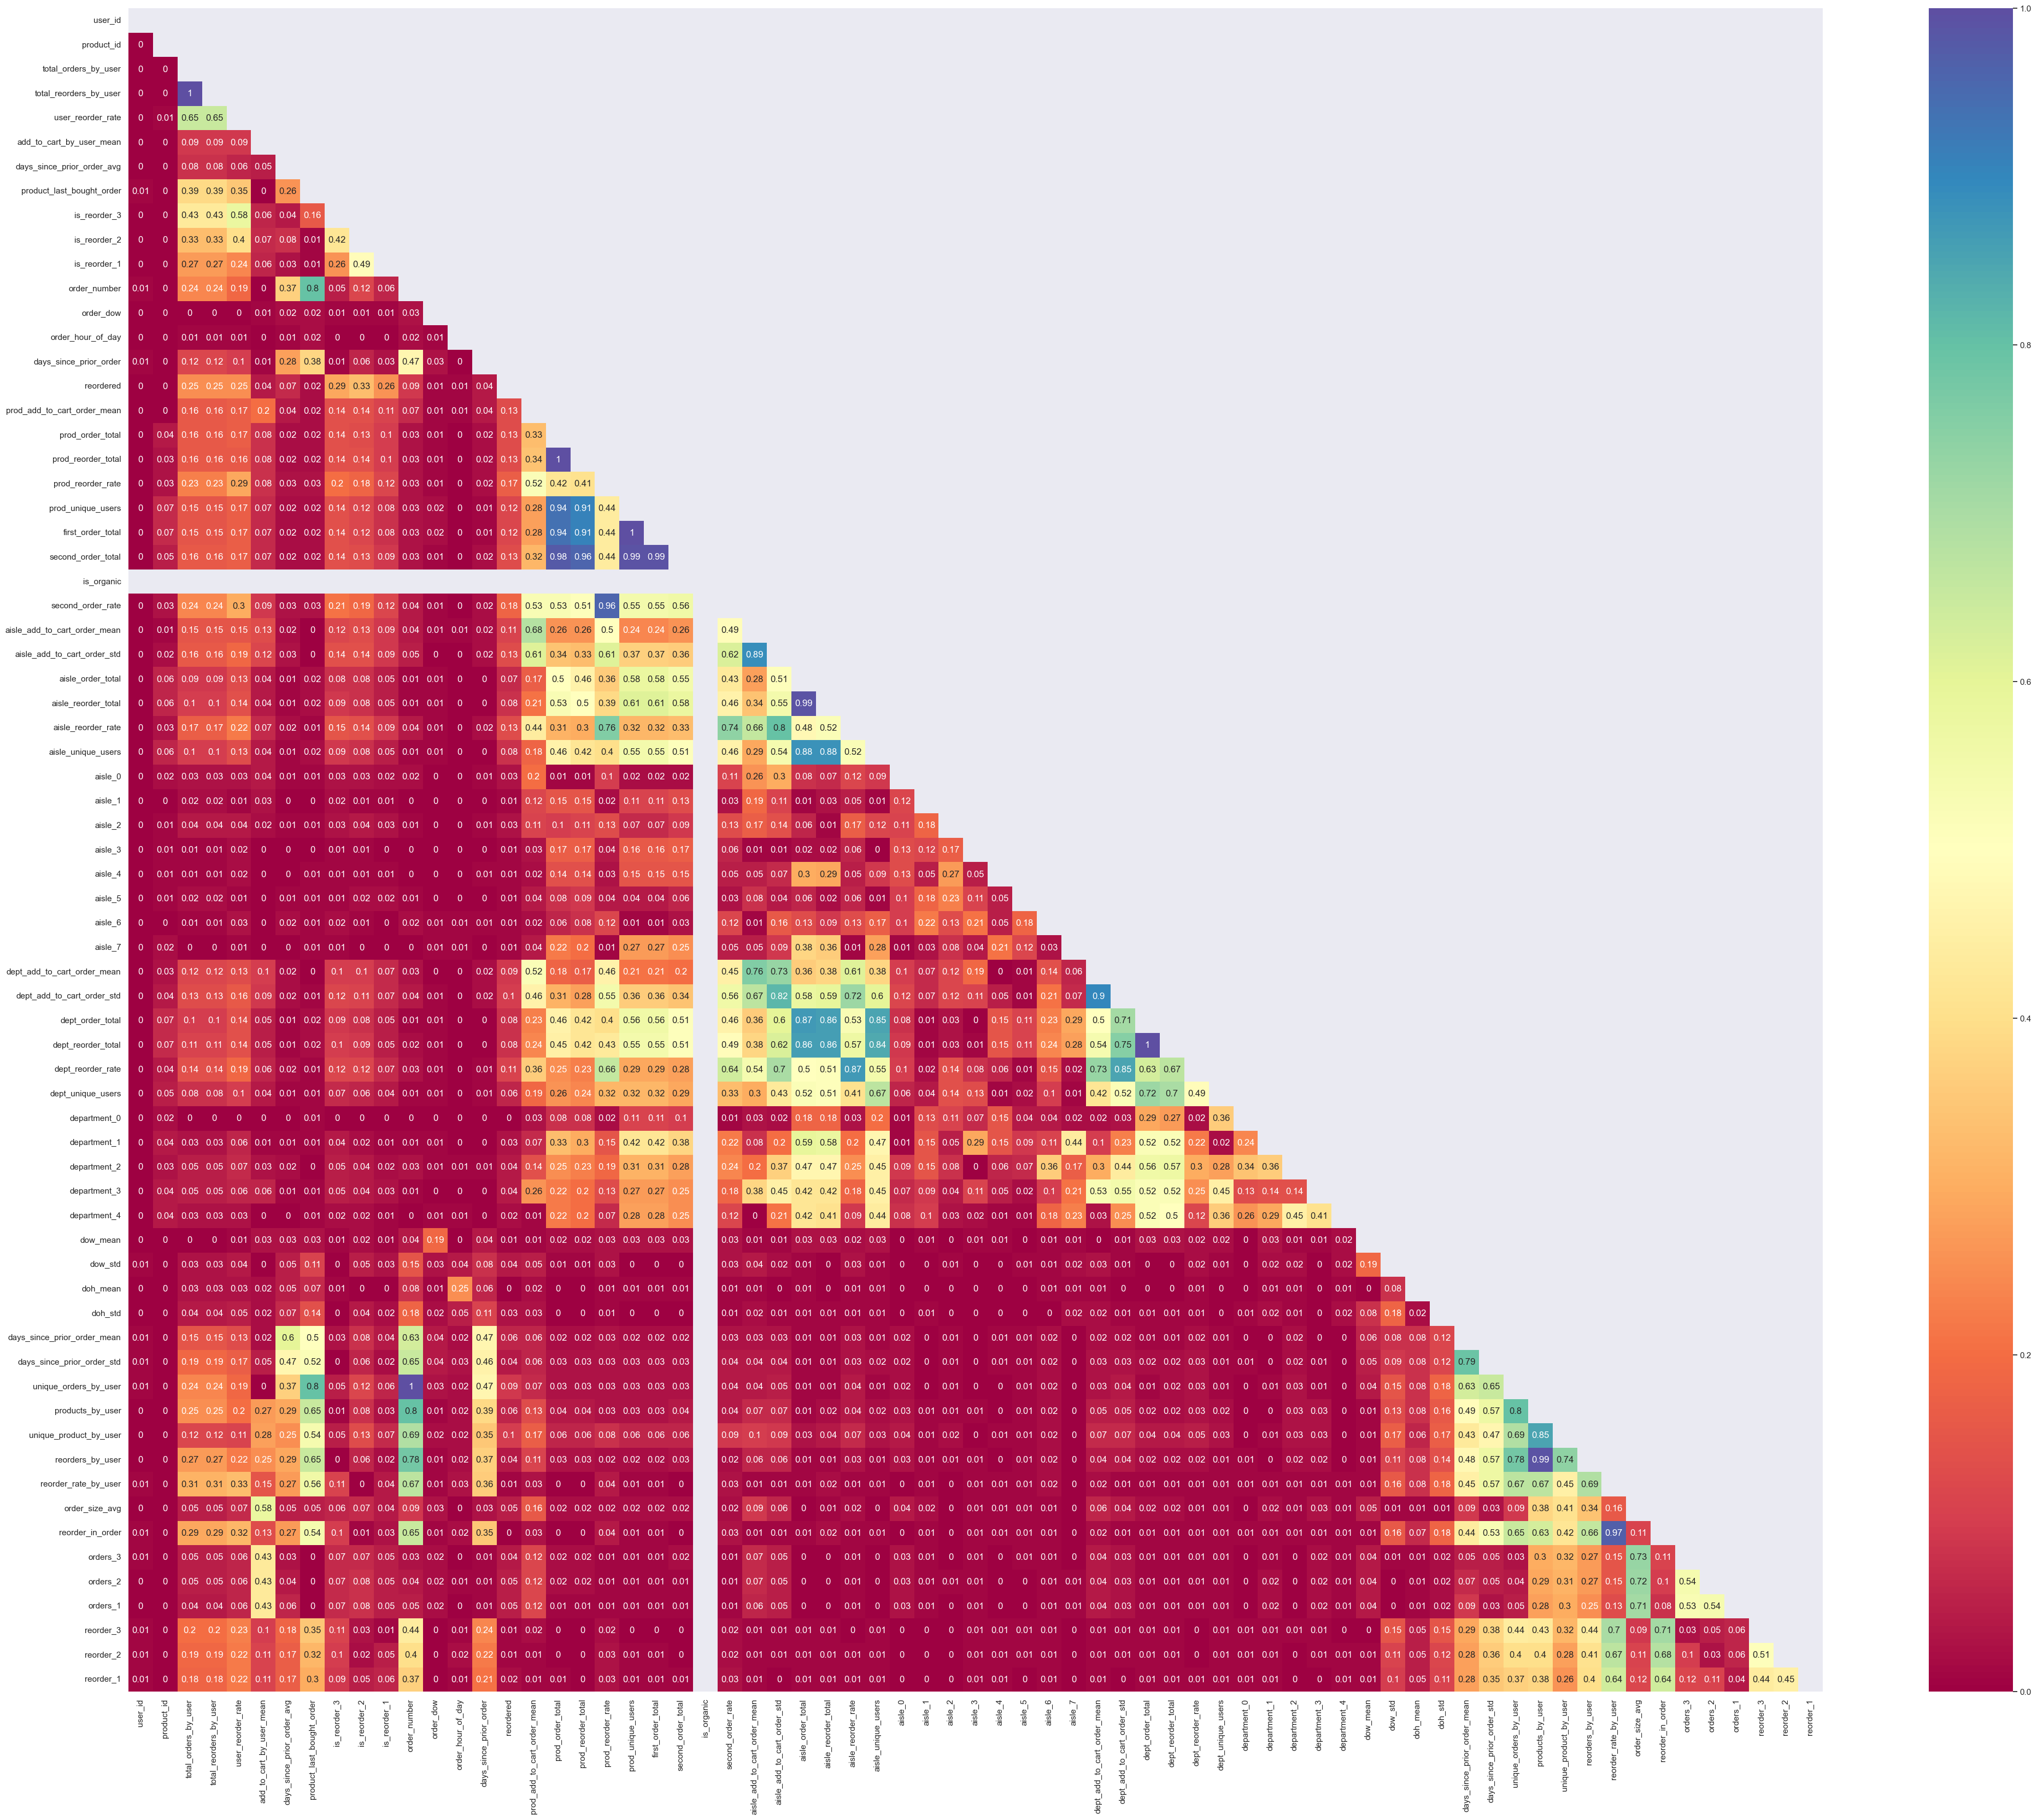

In [57]:
sns.set(rc={'figure.figsize':(50,40)})
mask = np.triu(np.ones_like(correlation_in_features))
sns.heatmap(data=correlation_in_features.round(2), annot=True, cmap="Spectral", mask=mask)
plt.show()

In [58]:
upper_right_triangle = correlation_in_features.where(np.triu(np.ones(correlation_in_features.shape),k=1).astype(bool))
print(upper_right_triangle)


                        user_id  product_id  total_orders_by_user  \
user_id                     NaN    0.000438              0.001855   
product_id                  NaN         NaN              0.003016   
total_orders_by_user        NaN         NaN                   NaN   
total_reorders_by_user      NaN         NaN                   NaN   
user_reorder_rate           NaN         NaN                   NaN   
...                         ...         ...                   ...   
orders_2                    NaN         NaN                   NaN   
orders_1                    NaN         NaN                   NaN   
reorder_3                   NaN         NaN                   NaN   
reorder_2                   NaN         NaN                   NaN   
reorder_1                   NaN         NaN                   NaN   

                        total_reorders_by_user  user_reorder_rate  \
user_id                               0.001855           0.003142   
product_id                       

In [59]:
drop_cols = [col for col in upper_right_triangle.columns if any(upper_right_triangle[col] > 0.80)]
print(drop_cols)


['total_reorders_by_user', 'prod_reorder_total', 'prod_unique_users', 'first_order_total', 'second_order_total', 'second_order_rate', 'aisle_add_to_cart_order_std', 'aisle_reorder_total', 'aisle_unique_users', 'dept_add_to_cart_order_std', 'dept_order_total', 'dept_reorder_total', 'dept_reorder_rate', 'unique_orders_by_user', 'unique_product_by_user', 'reorders_by_user', 'reorder_in_order']


In [60]:
corr_rem_data = dataframe.drop(drop_cols, axis=1)
print(corr_rem_data.head())


   user_id  product_id  total_orders_by_user  user_reorder_rate  \
0        1         196                  10.0           0.900000   
1        1       10258                   9.0           0.888889   
2        1       10326                   1.0           0.000000   
3        1       12427                  10.0           0.900000   
4        1       13032                   3.0           0.666667   

   add_to_cart_by_user_mean  days_since_prior_order_avg  \
0                  1.400000                   17.593750   
1                  3.333333                   19.562500   
2                  5.000000                   28.000000   
3                  3.300000                   17.593750   
4                  6.333333                   21.671875   

   product_last_bought_order  is_reorder_3  is_reorder_2  is_reorder_1  ...  \
0                       10.0           1.0           1.0           1.0  ...   
1                       10.0           1.0           1.0           1.0  ...   
2    

In [61]:
corr_rem_data.to_pickle('datasets/corr_removed_feature_data.pkl')

In [ ]:
dataframe = pd.read_pickle('datasets/corr_removed_feature_data.pkl')
dataframe.head()